# Image Classification using Tiny imagenet


> Image Classification using StanfordCars


- skip_showdoc: true
- skip_exec: true

## Data Preprocessing

In [ ]:
from torchinfo import summary

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, Dataset, random_split

import torch
import os
from PIL import Image

from tqdm import tqdm 
import matplotlib.pyplot as plt
import timm
import numpy as np
from datetime import datetime

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            split (string): Either 'train', 'val', or 'test'.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.classes = os.listdir(os.path.join(root_dir, split))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.class_name = self._get_names()
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, self.split, cls, 'images')
            for image_file in os.listdir(cls_dir):
                image_path = os.path.join(cls_dir, image_file)
                images.append((image_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

    def _get_names(self):
        entity_dict = {}
        # Open the text file
        with open('Data/tiny-imagenet-200/words.txt', 'r') as file:
            # Read each line
            for line in file:
                # Split the line into key and value using tab ('\t') as delimiter
                key, value = line.strip().split('\t')
        
                first = value.strip().split(',')
                # Add the key-value pair to the dictionary
                entity_dict[key] = first[0]
                # entity_dict.append(line)
        return entity_dict

In [ ]:
transform_default = transforms.Compose([
    # transforms.Resize((150, 150)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

main_dataset = TinyImageNetDataset(root_dir ='Data/tiny-imagenet-200', transform=transform_default)

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(main_dataset, [80000, 10000, 10000])

In [ ]:
len(train_dataset)

80000

In [ ]:
train_dataset

<torch.utils.data.dataset.Subset>

In [ ]:
train_dataset.__dict__.keys()

dict_keys(['dataset', 'indices'])

In [ ]:
len(train_dataset), len(test_dataset)

(80000, 10000)

In [ ]:
images, labels = train_dataset[10]
images.shape

torch.Size([3, 150, 150])

In [ ]:
# Define a function to display images
def show_image(dataset):
    # Access an image and its label from the dataset
    image, label = dataset
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_np.clip(0,1))
    plt.axis('off')
    plt.title(f' {main_dataset.class_name[main_dataset.classes[label]]}')
    plt.show()
    
   
# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        img_np = image.numpy().transpose((1, 2, 0))
        
        # Display image
        ax.imshow(img_np.clip(0,1))
        ax.axis('off')
        ax.set_title(f' {main_dataset.class_name[main_dataset.classes[label]]}')
    for ax in axes.flat[len(images):]:
        ax.axis('off')
        
    plt.show()

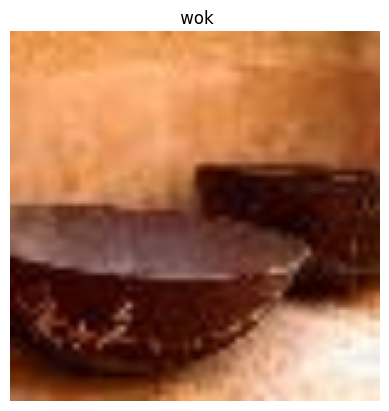

In [ ]:
show_image(train_dataset[6])

In [ ]:
def loaders(batch_size):

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=8)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False, 
                             num_workers=8)
    
    dataloaders = {'train': train_loader, 'val': test_loader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset) }
    return train_loader, test_loader, dataloaders, dataset_sizes

In [ ]:
batch_size = 32
train_loader, test_loader, dataloaders, dataset_sizes = loaders(batch_size)

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(test_loader)
images, labels = next(examples)
# ############## TENSORBOARD ########################
# img_grid = utils.make_grid(images)

# writer.add_image('Imagenette', img_grid)
# writer.flush()
# #sys.exit()
# ###################################################

In [ ]:
len(images)

32

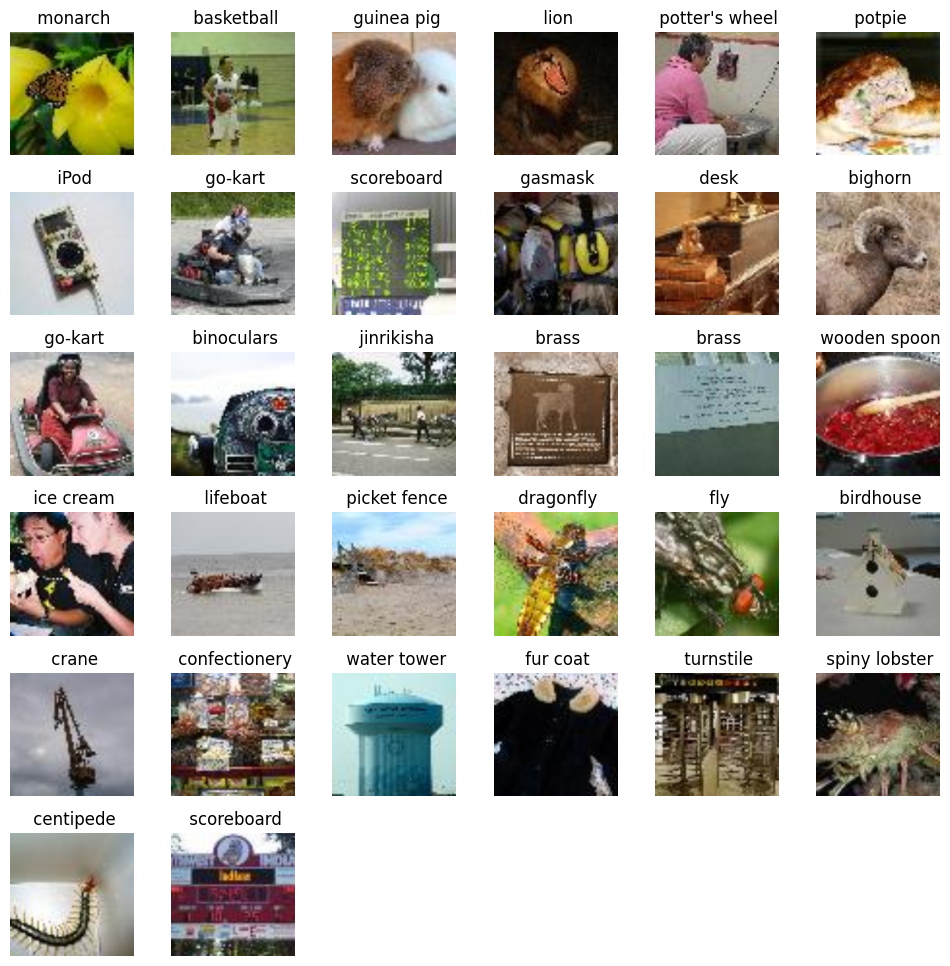

In [ ]:
show_images(images, labels)

## Model

In [ ]:
def train_model(model, criterion, 
                optimizer, scheduler, 
                train_loader, epoch,
                n_total_steps, record = 10):
    running_loss = 0.0
    running_correct = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):  
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % record == 0:
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / record, epoch * n_total_steps + i)
            running_accuracy = running_correct / record / len(images)
            writer.add_scalar('training accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            writer.flush()
            ###################################################
    scheduler.step()
    

def eval_model(model, criterion, 
               optimizer, scheduler, 
               test_loader, epoch,
               n_total_steps, batch_size):
    running_loss = 0.0
    running_correct = 0
    running_accuracy = 0
    
    model.eval()
    len_batch = 0
    for i, (images, labels) in enumerate(tqdm(test_loader)):  
        images = images.to(device)
        labels = labels.to(device)
        len_batch = len(images)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
    ############## TENSORBOARD ########################
    writer.add_scalar('val loss',
                      running_loss / len(test_loader),
                      (epoch+1) * n_total_steps)
    running_accuracy = running_correct / len(test_loader) / batch_size
    writer.add_scalar('val accuracy',
                      running_accuracy,
                      (epoch+1) * n_total_steps)

    writer.flush()
    ###################################################

In [ ]:
def build_model(model, criterion, optimizer,
                scheduler, num_epochs=5, batch_size = 32, record = 10):
    
    train_loader, test_loader, _, _ = loaders(batch_size)

    model = model.to(device)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        train_model(model, criterion,
                    optimizer, scheduler,
                    train_loader, epoch,
                    n_total_steps, record = 10)

        eval_model(model, criterion, 
                   optimizer, scheduler, 
                   test_loader, epoch, 
                   n_total_steps, batch_size)

    return model

In [ ]:
def start_tensorboard(file_name):
    ######################## TENSORBOARD ########################
    import sys
    from torch.utils.tensorboard import SummaryWriter
    from datetime import datetime
    # default `log_dir` is "runs" - we'll be more specific here
    formatted_time =  datetime.now().strftime("%H:%M:%S")
    
    writer = SummaryWriter(log_dir = f'{file_name} {formatted_time}')
    print(f'{file_name} {formatted_time}')
    
    writer.add_text('learning_rate', f'{learning_rate}')
    writer.add_text('epochs', f'{num_epochs}')
    writer.add_text('batch_size', f'{batch_size}')
    writer.add_text('criterion', f'{str(criterion)}')
    writer.add_text('optimizer', f'{str(optimizer)}')
    
    writer.flush()
    ###################################################
    return writer

## default setup

In [ ]:
# model = timm.create_model('resnet18',
#                           pretrained=True,
#                           num_classes=10)


In [ ]:
# learning_rate = 0.1
# num_epochs = 5
# batch_size = 64
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# ############## TENSORBOARD ########################
# import sys
# from torch.utils.tensorboard import SummaryWriter
# # default `log_dir` is "runs" - we'll be more specific here
# formatted_time =  datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

# writer = SummaryWriter(log_dir = f'runs/transforms everything {formatted_time}')

# writer.add_text('learning_rate', f'{learning_rate}')
# writer.add_text('epochs', f'{num_epochs}')
# writer.add_text('batch_size', f'{batch_size}')
# writer.add_text('criterion', f'{str(criterion)}')
# writer.add_text('optimizer', f'{str(optimizer)}')

# writer.add_graph(model, images)
# writer.flush()
# ###################################################

In [ ]:
# model = build_model(model = model,
#                     criterion = criterion,
#                     optimizer = optimizer,
#                     scheduler = step_lr_scheduler,
#                     num_epochs = num_epochs,
#                     batch_size = batch_size,
#                     record = 20)

In [ ]:
# del model
# torch.cuda.empty_cache()

In [ ]:
# ############## TENSORBOARD ########################
# writer.close()
# ###################################################

## Test Loop

In [ ]:
learning_rate = 0.1
num_epochs = 5
batch_size = 64
criterion = nn.CrossEntropyLoss()

In [ ]:
model = timm.create_model('resnet18',
                          pretrained=True,
                          num_classes=200)
model = model.to(device)

In [ ]:
for a in range(1):
    model = timm.create_model('resnet18',
                          pretrained=True,
                          num_classes=200)
    # optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    
    writer = start_tensorboard(f'imagenet/start {num_epochs} {batch_size} {learning_rate}')

    model = build_model(model = model,
                        criterion = criterion,
                        optimizer = optimizer,
                        scheduler = step_lr_scheduler,
                        num_epochs = num_epochs,
                        batch_size = batch_size,
                        record = 20)
    del model
    torch.cuda.empty_cache()
    
    ######################## TENSORBOARD ########################
    writer.close()
    ###################################################


imagenet/start 5 32 0.1 00:28:33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:07<00:00, 39.76it/s]
